robots.txt status: 200

=== ОПИСАТЕЛЬНАЯ СТАТИСТИКА ===
        HDI_Value  GDP_per_capita  Annual_Growth_%
count  155.000000      155.000000       154.000000
mean     0.751219    19083.525212         0.527143
std      0.150104    24994.369757         0.380452
min      0.414000      153.930218         0.020000
25%      0.631000     2642.144537         0.252500
50%      0.776000     8218.763071         0.425000
75%      0.882000    24887.389242         0.687500
max      0.972000   137516.587324         1.840000

=== КОРРЕЛЯЦИИ ===
                 HDI_Value  GDP_per_capita  Annual_Growth_%
HDI_Value         1.000000        0.719326        -0.498383
GDP_per_capita    0.719326        1.000000        -0.355742
Annual_Growth_%  -0.498383       -0.355742         1.000000

=== ИНТЕРПРЕТАЦИЯ ===
✅ Сильная положительная зависимость (r = 0.72): чем выше ВВП на душу населения, тем выше HDI.

=== ТОП-5 СТРАН ПО HDI ===
    Country  HDI_Value  GDP_per_capita
    Iceland      0.972    82703.857994
  

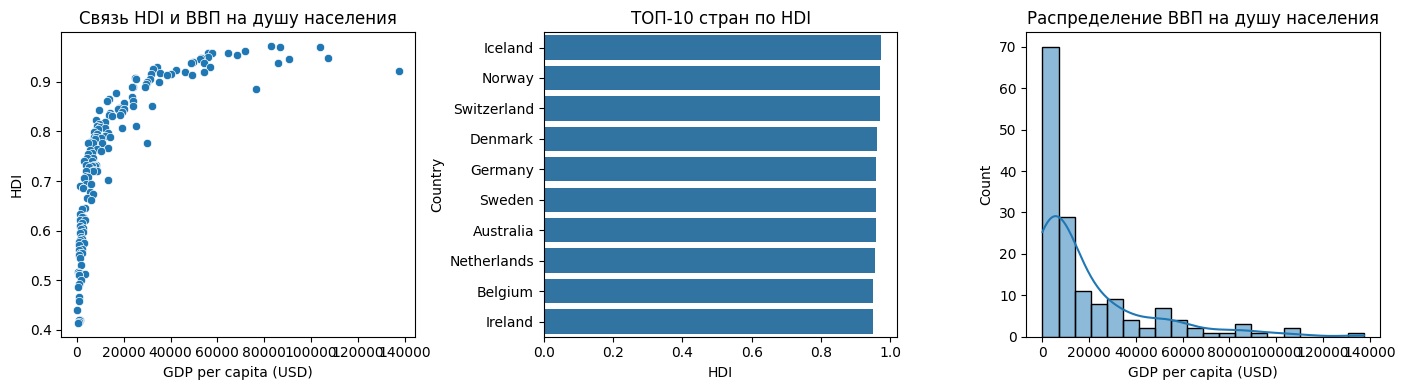


✅ Итог сохранён в merged_HDI_GDP.csv


In [2]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
import re
import difflib
from io import StringIO

# ---------- 1. HDI (Web Scraping) ----------
robots_url = "https://en.wikipedia.org/robots.txt"
headers = {"User-Agent": "Mozilla/5.0"}
robots_resp = requests.get(robots_url, headers=headers)
print("robots.txt status:", robots_resp.status_code)

url = "https://en.wikipedia.org/wiki/List_of_countries_by_Human_Development_Index"
resp = requests.get(url, headers=headers)
soup = BeautifulSoup(resp.text, "lxml")
tables = pd.read_html(StringIO(resp.text))

# Ищем таблицу с HDI
for t in tables:
    if "HDI value" in " ".join(t.columns.astype(str)):
        df_hdi = t
        break

# ---------- 2. GDP per capita (API, World Bank) ----------
url_gdp = "http://api.worldbank.org/v2/country/all/indicator/NY.GDP.PCAP.CD?format=json&date=2024&per_page=500"
resp_gdp = requests.get(url_gdp, headers=headers)
data = resp_gdp.json()[1]

df_gdp = pd.DataFrame([{
    "Country": c["country"]["value"],
    "GDP_per_capita": c["value"]
} for c in data if c["value"] is not None])


# Очистка
df_hdi = df_hdi.rename(columns={
    "Country or territory": "Country",
    "HDI value": "HDI_Value",
    "% annual growth (2010–2023)": "Annual_Growth_%"
})
df_hdi["Country"] = df_hdi["Country"].str.replace(r"\[.*?\]", "", regex=True).str.strip()
df_hdi["HDI_Value"] = pd.to_numeric(df_hdi["HDI_Value"], errors="coerce")
df_hdi["Annual_Growth_%"] = (
    df_hdi["Annual_Growth_%"]
    .astype(str)
    .str.replace("%","")
    .str.replace("▲","")
    .str.replace("▼","")
    .str.strip()
)
df_hdi["Annual_Growth_%"] = pd.to_numeric(df_hdi["Annual_Growth_%"], errors="coerce")

# ---------- 3. Нормализация названий стран ----------
def normalize_country(name):
    name = re.sub(r"\(.*?\)", "", name)
    name = name.replace("Republic of Korea", "South Korea")
    name = name.replace("Russian Federation", "Russia")
    name = name.replace("United States of America", "United States")
    name = name.strip()
    return name

df_hdi["Country"] = df_hdi["Country"].map(normalize_country)
df_gdp["Country"] = df_gdp["Country"].map(normalize_country)

# ---------- 4. Объединение ----------
df_merged = pd.merge(df_hdi, df_gdp, on="Country", how="inner")

# ---------- 5. Анализ ----------
print("\n=== ОПИСАТЕЛЬНАЯ СТАТИСТИКА ===")
print(df_merged[["HDI_Value", "GDP_per_capita", "Annual_Growth_%"]].describe())

corr = df_merged[["HDI_Value", "GDP_per_capita", "Annual_Growth_%"]].corr()
print("\n=== КОРРЕЛЯЦИИ ===")
print(corr)

corr_hdi_gdp = corr.loc["HDI_Value", "GDP_per_capita"]

print("\n=== ИНТЕРПРЕТАЦИЯ ===")
if corr_hdi_gdp > 0.7:
    print(f"✅ Сильная положительная зависимость (r = {corr_hdi_gdp:.2f}): чем выше ВВП на душу населения, тем выше HDI.")
elif corr_hdi_gdp > 0.4:
    print(f"🟨 Умеренная положительная зависимость (r = {corr_hdi_gdp:.2f}).")
elif corr_hdi_gdp > 0.1:
    print(f"🟩 Слабая положительная зависимость (r = {corr_hdi_gdp:.2f}).")
elif corr_hdi_gdp < -0.1:
    print(f"🔻 Отрицательная зависимость (r = {corr_hdi_gdp:.2f}): чем выше ВВП, тем ниже HDI — аномалия.")
else:
    print(f"⚪ Зависимость между ВВП и HDI практически отсутствует (r = {corr_hdi_gdp:.2f}).")

df_sorted_hdi = df_merged.sort_values("HDI_Value", ascending=False)

print("\n=== ТОП-5 СТРАН ПО HDI ===")
print(df_sorted_hdi[["Country", "HDI_Value", "GDP_per_capita"]].head(5).to_string(index=False))

print("\n=== НИЗШИЕ 5 СТРАН ПО HDI ===")
print(df_sorted_hdi[["Country", "HDI_Value", "GDP_per_capita"]].tail(5).to_string(index=False))

# ---------- 6. Визуализация ----------
plt.figure(figsize=(14, 4))

# 1. Корреляция HDI и ВВП
plt.subplot(1, 3, 1)
sns.scatterplot(data=df_merged, x="GDP_per_capita", y="HDI_Value")
plt.title("Связь HDI и ВВП на душу населения")
plt.xlabel("GDP per capita (USD)")
plt.ylabel("HDI")

# 2. Топ-10 стран по HDI
plt.subplot(1, 3, 2)
top_hdi = df_merged.nlargest(10, "HDI_Value")
sns.barplot(data=top_hdi, y="Country", x="HDI_Value")
plt.title("ТОП-10 стран по HDI")
plt.xlabel("HDI")
plt.ylabel("Country")

# 3. Гистограмма распределения ВВП
plt.subplot(1, 3, 3)
sns.histplot(df_merged["GDP_per_capita"], bins=20, kde=True)
plt.title("Распределение ВВП на душу населения")
plt.xlabel("GDP per capita (USD)")

plt.tight_layout()
plt.show()

# ---------- 7. Сохранение итогов ----------
df_merged.to_csv("merged_HDI_GDP.csv", index=False, encoding="utf-8")
print("\n✅ Итог сохранён в merged_HDI_GDP.csv")
